# Cliente y librerías

In [58]:
import pandas as pd
from pymongo import MongoClient
import os
import matplotlib.pyplot as plt

In [59]:
# Cliente y base de datos
client = MongoClient("mongodb://localhost:27017/")
db = client["my_database"]

# Relative path
relative_path = os.getcwd()

# Lista de archivos CSV y colecciones
list_csv = ["/superstore_orders.csv", "/superstore_people.csv", "/superstore_returns.csv"]
list_collection = ["superstore_orders", "superstore_people", "superstore_returns"]


# Creación de base de datos e insertar datos desde CSV

In [ ]:
for i in range(len(list_csv)):
    # Colección
    collection = db[list_collection[i]]

    # Leer el archivo CSV
    ruta_csv = relative_path + list_csv[i]
    df = pd.read_csv(ruta_csv, delimiter=';')

    # Convertir el DataFrame de pandas a una lista de diccionarios
    datos_a_insertar = df.to_dict(orient="records")

    # Insertar los datos en la colección
    resultado = collection.insert_many(datos_a_insertar)

    print(f"Se han insertado {len(resultado.inserted_ids)} documentos en la colección {list_collection[i]}")

Se han insertado 10994 documentos en la colección superstore_orders
Se han insertado 4 documentos en la colección superstore_people
Se han insertado 296 documentos en la colección superstore_returns


# Consultas avanzadas

In [60]:
# Ver algún docuemnto de ejemplo
db.superstore_orders.find_one()

{'_id': ObjectId('67588a92735179286283ffa7'),
 'Row ID': 1.0,
 'Order ID': 'CA-2016-152156',
 'Order Date': '8/11/2016',
 'Ship Date': '11/11/2016',
 'Ship Mode': 'Second Class',
 'Customer ID': 'CG-12520',
 'Customer Name': 'Claire Gute',
 'Segment': 'Consumer',
 'Country': 'United States',
 'City': 'Henderson',
 'State': 'Kentucky',
 'Postal Code': 42420.0,
 'Region': 'South',
 'Product ID': 'FUR-BO-10001798',
 'Category': 'Furniture',
 'Sub-Category': 'Bookcases',
 'Product Name': 'Bush Somerset Collection Bookcase',
 'Sales': '261,96',
 'Quantity': 2.0,
 'Discount': '0',
 'Profit': '41,9136'}

In [61]:
# Consulta 1
returns_count = db.superstore_returns.count_documents({"Returned": "Yes"})
print(f"Total de devoluciones: {returns_count}")

# Consulta 2
returned_orders_ids = db.superstore_returns.find({"Returned": "Yes"}, {"Order ID": 1, "_id": 0})
print("IDs pedidos devueltas:")
for order in returned_orders_ids:
    print(order)

Total de devoluciones: 296
IDs pedidos devueltas:
{'Order ID': 'CA-2017-153822'}
{'Order ID': 'CA-2017-129707'}
{'Order ID': 'CA-2014-152345'}
{'Order ID': 'CA-2015-156440'}
{'Order ID': 'US-2017-155999'}
{'Order ID': 'CA-2014-157924'}
{'Order ID': 'CA-2017-131807'}
{'Order ID': 'CA-2016-124527'}
{'Order ID': 'CA-2017-135692'}
{'Order ID': 'CA-2014-123225'}
{'Order ID': 'CA-2017-145772'}
{'Order ID': 'US-2014-105137'}
{'Order ID': 'CA-2017-101805'}
{'Order ID': 'CA-2016-111682'}
{'Order ID': 'CA-2017-131492'}
{'Order ID': 'CA-2015-104129'}
{'Order ID': 'CA-2017-117926'}
{'Order ID': 'US-2016-115952'}
{'Order ID': 'CA-2015-155761'}
{'Order ID': 'CA-2017-100111'}
{'Order ID': 'CA-2014-156349'}
{'Order ID': 'CA-2016-118899'}
{'Order ID': 'CA-2017-108294'}
{'Order ID': 'US-2017-123834'}
{'Order ID': 'CA-2015-168480'}
{'Order ID': 'CA-2017-122007'}
{'Order ID': 'CA-2017-128965'}
{'Order ID': 'CA-2015-169397'}
{'Order ID': 'CA-2015-168564'}
{'Order ID': 'CA-2014-102652'}
{'Order ID': 'CA-201

In [34]:

# Consulta 3
returned_orders_details = db.superstore_orders.aggregate([
    {
        "$lookup": {
            "from": "superstore_returns",
            "localField": "Order ID",
            "foreignField": "Order ID",
            "as": "return_info"
        }
    },
    {
        "$match": {
            "return_info.Returned": "Yes"
        }
    }
])

print("Información detallada de órdenes devueltas:")
for order in returned_orders_details:
    print(order)

Información detallada de órdenes devueltas:
{'_id': ObjectId('67588a92735179286283ffb9'), 'Row ID': 19.0, 'Order ID': 'CA-2014-143336', 'Order Date': '27/8/2014', 'Ship Date': '1/9/2014', 'Ship Mode': 'Second Class', 'Customer ID': 'ZD-21925', 'Customer Name': 'Zuschuss Donatelli', 'Segment': 'Consumer', 'Country': 'United States', 'City': 'San Francisco', 'State': 'California', 'Postal Code': 94109.0, 'Region': 'West', 'Product ID': 'OFF-AR-10003056', 'Category': 'Office Supplies', 'Sub-Category': 'Art', 'Product Name': 'Newell 341', 'Sales': '8,56', 'Quantity': 2.0, 'Discount': '0', 'Profit': '2,4824', 'return_info': [{'_id': ObjectId('67588a927351792862842b3c'), 'Returned': 'Yes', 'Order ID': 'CA-2014-143336'}]}
{'_id': ObjectId('67588a92735179286283ffba'), 'Row ID': 20.0, 'Order ID': 'CA-2014-143336', 'Order Date': '27/8/2014', 'Ship Date': '1/9/2014', 'Ship Mode': 'Second Class', 'Customer ID': 'ZD-21925', 'Customer Name': 'Zuschuss Donatelli', 'Segment': 'Consumer', 'Country': 'U

In [ ]:
# Consulta 4
top_customers_by_sales = db.superstore_orders.aggregate([
    {
        "$match": {  # Filtrar documentos donde Sales no es nan
            "Sales": {"$type": 2} 
        }
    },
    {
        "$group": {
            "_id": "$Customer ID",
            "totalSales": {
                "$sum": {
                    "$toDouble": {
                        "$replaceOne": {
                            "input": "$Sales",
                            "find": ",",
                            "replacement": "."
                        }
                    }
                }
            },
             "customerName": {"$first": "$Customer Name"} # Obtener el nombre del cliente
        }
    },
    {
        "$sort": {"totalSales": -1}
    },
    {
        "$limit": 3
    },
     {
        "$project": {
            "_id": 0,
            "Customer ID": "$_id",
            "Customer Name": "$customerName", # Mostrar el nombre del cliente
            "Total Sales": "$totalSales"

        }
    }
])

print("Top 3 clientes con mayores ventas:")
for customer in top_customers_by_sales:
    print(customer)

Top 3 clientes con mayores ventas:
{'Customer ID': 'SM-20320', 'Customer Name': 'Sean Miller', 'Total Sales': 25043.05}
{'Customer ID': 'TC-20980', 'Customer Name': 'Tamara Chand', 'Total Sales': 19052.218}
{'Customer ID': 'RB-19360', 'Customer Name': 'Raymond Buch', 'Total Sales': 15117.339}


In [ ]:
# Consulta 5
sales_by_region_with_person = db.superstore_orders.aggregate([
     {
        "$match": {  # Filtrar documentos donde Sales no es nan
            "Sales": {"$type": 2} 
        }
    },
    {
        "$group": {
            "_id": "$Region",
            "totalSales": {"$sum": {"$toDouble": {"$replaceOne": {"input": "$Sales", "find": ",", "replacement": "."}}}}
        }
    },
    {
        "$lookup": {
            "from": "superstore_people",
            "localField": "_id",
            "foreignField": "Region",
            "as": "person_info"
        }
    }
])
print("Ventas totales por región con información del comercial de dicha región:")
for region in sales_by_region_with_person:
    print(region)

Ventas totales por región con información de la persona asignada:
{'_id': 'East', 'totalSales': 678781.24, 'person_info': [{'_id': ObjectId('67588a927351792862842a9a'), 'Person': 'Chuck Magee', 'Region': 'East'}]}
{'_id': 'West', 'totalSales': 725457.8245, 'person_info': [{'_id': ObjectId('67588a927351792862842a99'), 'Person': 'Anna Andreadi', 'Region': 'West'}]}
{'_id': 'South', 'totalSales': 391721.905, 'person_info': [{'_id': ObjectId('67588a927351792862842a9c'), 'Person': 'Cassandra Brandow', 'Region': 'South'}]}
{'_id': 'Central', 'totalSales': 501239.8908, 'person_info': [{'_id': ObjectId('67588a927351792862842a9b'), 'Person': 'Kelly Williams', 'Region': 'Central'}]}


In [ ]:
client.close()

# Gráficos en Python

In [ ]:
# Recargar los datos utilizando el delimitador correcto
orders = pd.read_csv(relative_path + '/superstore_orders.csv', delimiter=';')

# Convertir valores numéricos con coma a punto (corregir error de formato en el csv)
for col in ['Sales', 'Profit', 'Discount']:
    orders[col] = orders[col].replace(',', '.', regex=True).astype(float)

# Verificar los datos después de la carga y conversión
orders.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1.0,CA-2016-152156,8/11/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2.0,0.00,41.9136
1,2.0,CA-2016-152156,8/11/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3.0,0.00,219.5820
2,3.0,CA-2016-138688,12/6/2016,16/6/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2.0,0.00,6.8714
3,4.0,US-2015-108966,11/10/2015,18/10/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5.0,0.45,-383.0310
4,5.0,US-2015-108966,11/10/2015,18/10/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2.0,0.20,2.5164


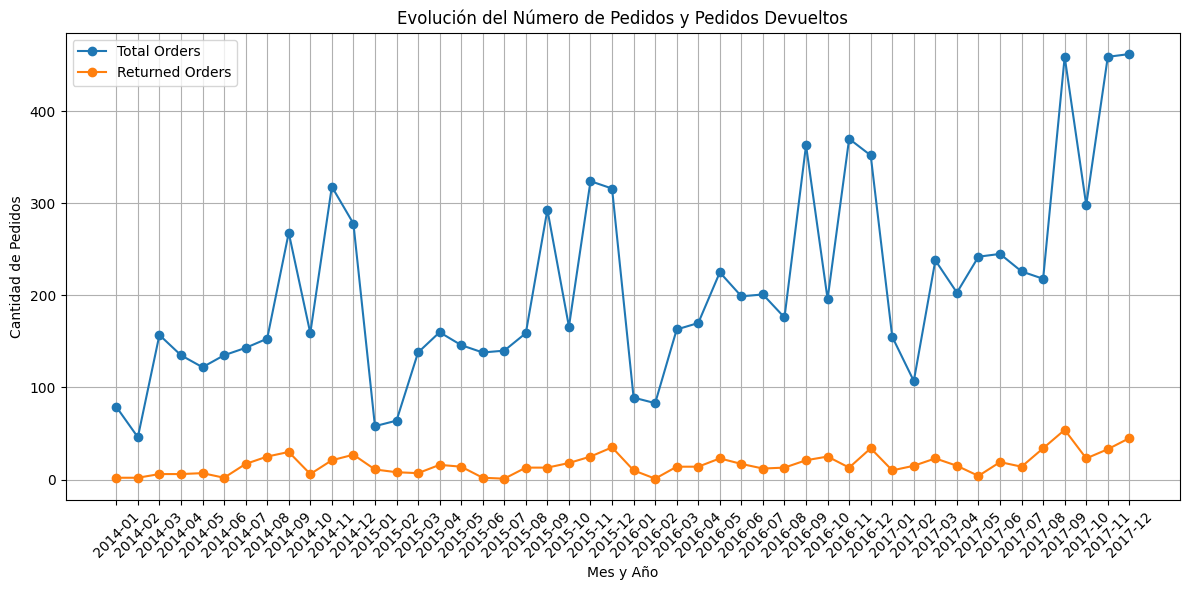

In [ ]:
# Una vez limpio, vamos a hacer los gráficos
# Convertir las fechas y preparar la agrupación como antes
orders['Order Date'] = pd.to_datetime(orders['Order Date'], dayfirst=True)
orders['YearMonth'] = orders['Order Date'].dt.to_period('M')

# Contar el número de pedidos por mes
orders_count = orders.groupby('YearMonth').size().reset_index(name='Total Orders')

# Procesar el archivo de devoluciones como antes
returns = pd.read_csv(relative_path + '/superstore_returns.csv', delimiter=';')
returns_merged = pd.merge(orders, returns, on='Order ID', how='left')
returns_merged['Returned'] = returns_merged['Returned'].notnull()

# Contar el número de pedidos devueltos por mes
returns_count = (
    returns_merged[returns_merged['Returned']]
    .groupby('YearMonth')
    .size()
    .reset_index(name='Returned Orders')
)

# Combinar los datos de pedidos y devoluciones
evolution_data = pd.merge(
    orders_count, 
    returns_count, 
    on='YearMonth', 
    how='left'
).fillna(0)

# Convertir YearMonth a string para fromar el eje X
evolution_data['YearMonth'] = evolution_data['YearMonth'].astype(str)

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.plot(
    evolution_data['YearMonth'], 
    evolution_data['Total Orders'], 
    label='Total Orders', 
    marker='o'
)
plt.plot(
    evolution_data['YearMonth'], 
    evolution_data['Returned Orders'], 
    label='Returned Orders', 
    marker='o'
)

plt.title('Evolución del Número de Pedidos y Pedidos Devueltos')
plt.xlabel('Mes y Año')
plt.ylabel('Cantidad de Pedidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()


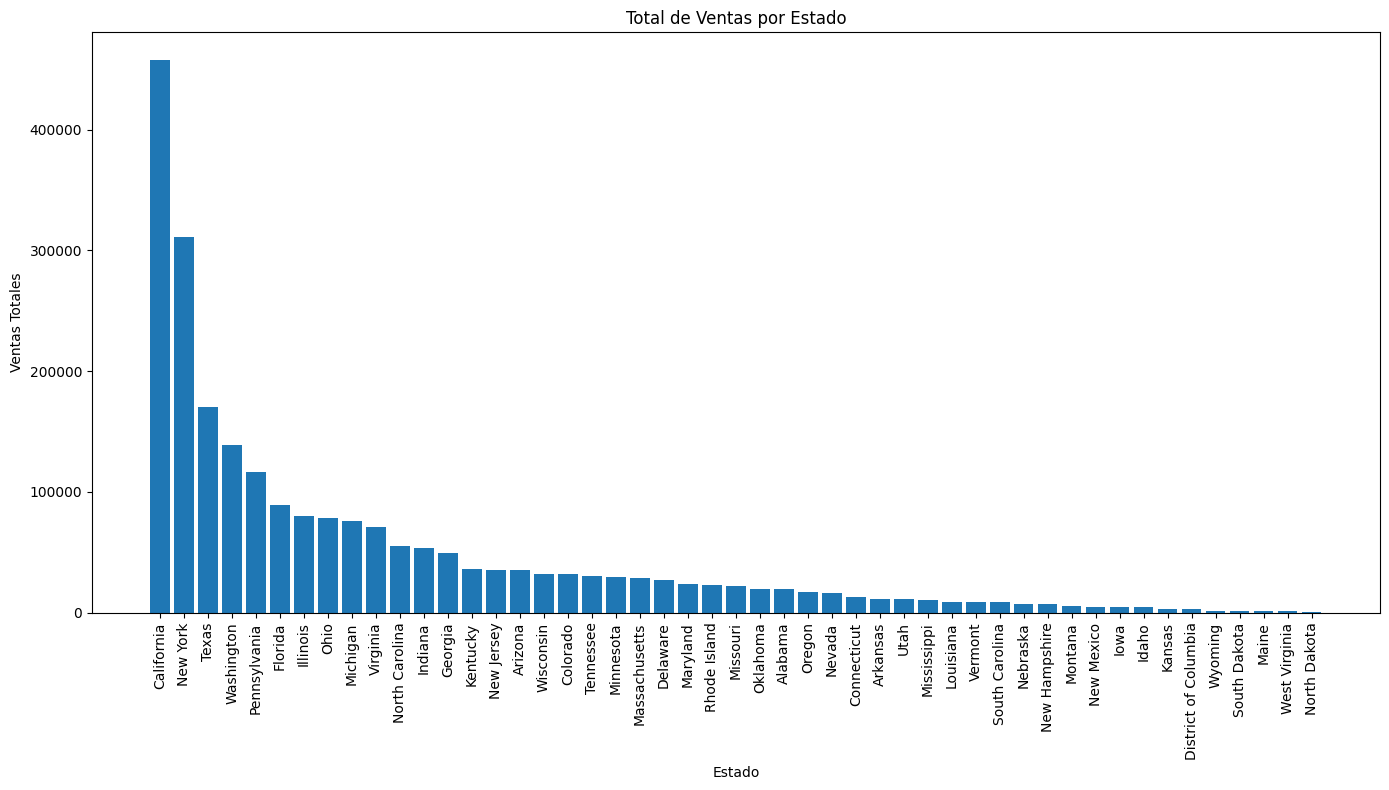

In [54]:
# Agrupar los datos para calcular el total de ventas por estado
sales_by_state = orders.groupby('State')['Sales'].sum().reset_index()

# Ordenar los datos por ventas para mejorar la visualización
sales_by_state = sales_by_state.sort_values(by='Sales', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(14, 8))
plt.bar(sales_by_state['State'], sales_by_state['Sales'])

plt.title('Total de Ventas por Estado')
plt.xlabel('Estado')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


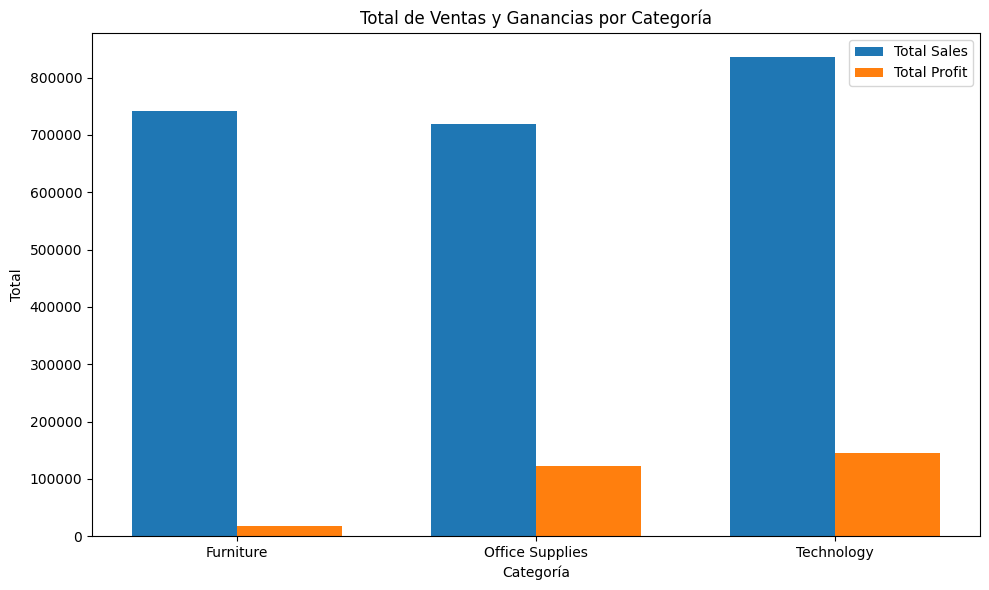

In [55]:
# Agrupar los datos para calcular el total de ventas y ganancias por categoría
sales_profit_by_category = orders.groupby('Category')[['Sales', 'Profit']].sum().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bar_width = 0.35
categories = sales_profit_by_category['Category']

# Posiciones de las barras
x = range(len(categories))

# Gráficas de ventas y ganancias
plt.bar(x, sales_profit_by_category['Sales'], width=bar_width, label='Total Sales', align='center')
plt.bar(
    [pos + bar_width for pos in x],
    sales_profit_by_category['Profit'],
    width=bar_width,
    label='Total Profit',
    align='center'
)

plt.title('Total de Ventas y Ganancias por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Total')
plt.xticks([pos + bar_width / 2 for pos in x], categories)
plt.legend()
plt.tight_layout()

plt.show()


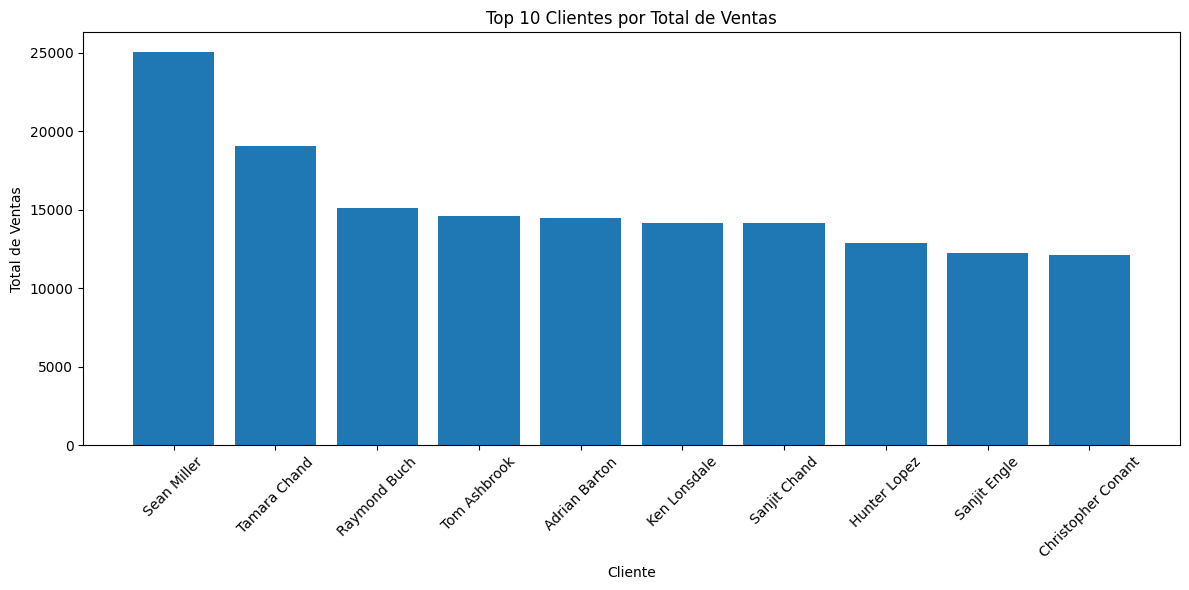

In [56]:
# Agrupar los datos para calcular el total de ventas por cliente
sales_by_customer = orders.groupby('Customer Name')['Sales'].sum().reset_index()

# Ordenar por ventas y seleccionar el top 10
top_customers = sales_by_customer.sort_values(by='Sales', ascending=False).head(10)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top_customers['Customer Name'], top_customers['Sales'])

plt.title('Top 10 Clientes por Total de Ventas')
plt.xlabel('Cliente')
plt.ylabel('Total de Ventas')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


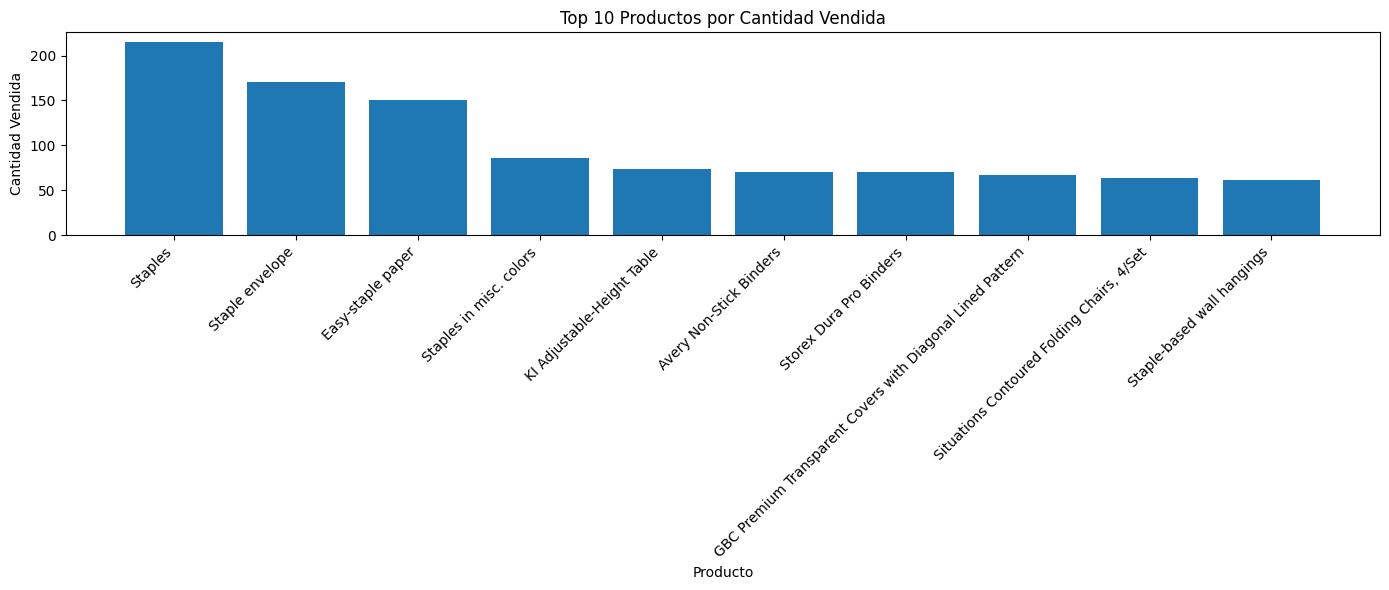

In [57]:
# Agrupar los datos para calcular la cantidad total vendida por producto
quantity_by_product = orders.groupby('Product Name')['Quantity'].sum().reset_index()

# Ordenar por cantidad y seleccionar los 10 productos más vendidos
top_products = quantity_by_product.sort_values(by='Quantity', ascending=False).head(10)

# Crear el gráfico de barras
plt.figure(figsize=(14, 6))
plt.bar(top_products['Product Name'], top_products['Quantity'])

plt.title('Top 10 Productos por Cantidad Vendida')
plt.xlabel('Producto')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
